# Segmentation Bệnh Tràn khí màng phổi(Pneumothorax) bằng Unet

Tràn khí màng phổi là bệnh lý trong khoang màng phổi bị tích tụ khí làm cho phổi bị xẹp thụ động, ảnh hưởng đến chức năng hô hấp của cơ thể. Tràn khí màng phổi có rất nhiều nguyên nhân khác nhau cũng như cách chẩn đoán và điều trị, tùy thuộc vào tràn khí màng phổi tự phát hay tràn khí màng phổi tái phát.

## Download dataset về pneumothorax

In [1]:
!pip install kaggle 
!pip install pydicom

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"duongduccuong","key":"3c8d79a36c35cfc8354e9c88a4e4dc42"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data
!unzip "/content/siim-acr-pneumothorax-segmentation-data.zip"


Streaming output truncated to the last 5000 lines.
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2137.1517875171.310659/1.2.276.0.7230010.3.1.3.8323329.2137.1517875171.310658/1.2.276.0.7230010.3.1.4.8323329.2137.1517875171.310660.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2138.1517875171.323419/1.2.276.0.7230010.3.1.3.8323329.2138.1517875171.323418/1.2.276.0.7230010.3.1.4.8323329.2138.1517875171.323420.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2139.1517875171.325963/1.2.276.0.7230010.3.1.3.8323329.2139.1517875171.325962/1.2.276.0.7230010.3.1.4.8323329.2139.1517875171.325964.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2140.1517875171.331423/1.2.276.0.7230010.3.1.3.8323329.2140.1517875171.331422/1.2.276.0.7230010.3.1.4.8323329.2140.1517875171.331424.dcm  
  inflating: pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2141.151

# Import các thư viện cần thiết

In [2]:
import os
os.chdir("/content/drive/MyDrive/Project/Tenflow_segment")
import tensorflow as tf
# from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
import pandas as pd 
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import albumentations
from sklearn.model_selection import train_test_split

In [3]:
# load model craft-self
from transformations import Compose, Resize, DenseTarget, AlbuSeg2d
from transformations import MoveAxis, Normalize01
from evalues import evaluemodel
from metrics import dice_coef
from customdata import DataGenerator
from rle2mask import rle2mask

# Kiểm tra dataset
(bao nhiêu ảnh để train, bao nhiêu để test, đọc vài dòng đầu từ file csv)

In [4]:
df_patients = pd.read_csv('df_patients.csv') # load file csv prapre
trains, vals = train_test_split(df_patients,shuffle=True)

# create date generator

In [12]:
size_data = (224, 224)
n_channels_x = 1
n_channels_y = 1

BATCH_SIZE = 15

# create image augumentation
albu = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.OneOf([
        albumentations.RandomContrast(),
        albumentations.RandomGamma(),
        albumentations.RandomBrightness(),
        ], p=0.3),
    albumentations.OneOf([
        albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albumentations.GridDistortion(),
        albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albumentations.ShiftScaleRotate(),
])

In [13]:
transforms_trainning = Compose([
    DenseTarget(),
    Resize(input_size=size_data+(n_channels_x,), 
           target_size=size_data+(n_channels_y,)),

    # Normalize01(),
    AlbuSeg2d(albu=albu)
])

transforms_validation = Compose([
    Resize(input_size=size_data+(n_channels_x,), 
           target_size=size_data+(n_channels_y,)),
    # Normalize01(),
])


image_generator = DataGenerator(
    all_filenames = trains,
    batch_size = BATCH_SIZE,
    input_dim = size_data,
    n_channels = n_channels_x,
    transform = transforms_trainning,
    shuffle = True
)
valid_generator = DataGenerator(
    all_filenames = vals,
    batch_size = BATCH_SIZE,
    input_dim = size_data,
    n_channels = n_channels_y,
    transform = transforms_validation,
    shuffle = True
)

X, y = image_generator.__getitem__(2)

print(X.shape, X.max())
print(y.shape, y.max())

(15, 224, 224, 1) 0.9929971988795532
(15, 224, 224, 1) 1.0


# creadet model

In [51]:

INPUT_SHAPE = 224
OUTPUT_SHAPE = 224

def _downsample_cnn_block(block_input, channel, is_first = False):
    if is_first:  
        conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(block_input)
        conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
        return [block_input, conv1, conv2]
    else:
        maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
        conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(maxpool)
        conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
        return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):  
    # Upsampling block
    uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
    # Crop block counterpart
    shape_input = uppool1.shape[2]
    shape_counterpart = block_counterpart.shape[2]
    crop_size = int((shape_counterpart-shape_input)/2)
    # Có thể bỏ qua crop vì các nhánh đã bằng kích thước.
    block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
    concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    if is_last:
        conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv2)
        return [concat, conv1, conv2, conv3]
    return [uppool1, concat, conv1, conv2]

from tensorflow.keras.optimizers import Adam

def _create_model2():
    ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 1)), channel=64, is_first = True)
    ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
    ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
    ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
    ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
    us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
    us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
    us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
    us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
    model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=dice_coef)
    return model

model = _create_model2()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.summary()




Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 224, 224, 64) 640         input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

# train model

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("Epoch : ", epoch,"/",EPOCHS)
    history=model.fit(image_generator,
        validation_data = valid_generator,
        batch_size = 8,
        epochs = 1,
        #   callbacks = (EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))
        )
    predict_path(vals ,model)

# Fine tunning model

In [7]:
vgg16_model = tf.keras.applications.VGG16(input_shape=(224, 224, 1), weights=None, include_top=False)

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable=False

In [10]:
INPUT_SHAPE = 224
OUTPUT_SHAPE = 224

def _downsample_cnn_block(block_input, vgg16, is_first = False):
    if is_first:  
        conv1 = Sequential(vgg16)(block_input)
        return [block_input, conv1]
    else:
        maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
        conv1 = conv1 = Sequential(vgg16)(maxpool)
        return [maxpool, conv1]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):  
    # Upsampling block
    uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
    # Crop block counterpart
    shape_input = uppool1.shape[2]
    shape_counterpart = block_counterpart.shape[2]
    crop_size = int((shape_counterpart-shape_input)/2)
    # Có thể bỏ qua crop vì các nhánh đã bằng kích thước.
    block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
    concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    if is_last:
        conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv2)
        return [concat, conv1, conv2, conv3]
    return [uppool1, concat, conv1, conv2]

def _upsample_cnn_test(block_input, channel, is_last = False):
    # [28, 28, 1] > [244, 244, 1] k=13, s=9, p=6
     uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=8, strides=8)(block_input)
     return [uppool1]

from tensorflow.keras.optimizers import Adam

def _create():
    ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 1)), vgg16_model.layers[1:3], is_first = True)
    ds_block2 = _downsample_cnn_block(ds_block1[-1], vgg16_model.layers[4:6])
    ds_block3 = _downsample_cnn_block(ds_block2[-1], vgg16_model.layers[7:10])
    ds_block4 = _downsample_cnn_block(ds_block3[-1], vgg16_model.layers[11:14])
    # ds_block5 = _downsample_cnn_block(ds_block4[-1], vgg16_model.layers[11:14])
    # us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
    # us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
    # us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
    # us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
    us_block1 = _upsample_cnn_test(ds_block4[-1], channel=1)
    model_test = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
    model_test.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=dice_coef)
    return model_test

model_test = _create()

model_test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 64)      37568     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 112, 112, 128)     221440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 56, 56, 256)       1475328   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0     

In [19]:
from rle2mask import rle2mask
import numpy as np 
import matplotlib.pyplot as plt

def evaluemodel(vals, model, size=(256,256)):
    val = df_pneumo = vals[vals["EncodedPixels"] != ' -1']

        
    mask = rle2mask(val.values[3][1], 1024, 1024)
    mask = np.rot90(mask, 3) #rotating three times 90 to the right place
    mask = np.flip(mask, axis=1)
    mask = cv2.resize(mask, size)
    img = pydicom.read_file(val.values[3][-1]).pixel_array
    img = cv2.resize(img,size)
    

    fig = plt.figure(figsize=(15, 10))
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(img, cmap='bone') #original x-ray
    a.set_title("Original x-ray image")
    plt.grid(False)
    plt.axis("off")
    

    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(mask, cmap='binary')
    a.set_title("The mask")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)

    a = fig.add_subplot(1, 3, 3)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.imshow(pred, cmap='binary', alpha=0.3)
    a.set_title("Mask on the x-ray: air in the pleura")

    plt.show()


Epoch :  0 / 10
533/533 [==============================] - 858s 2s/step - loss: 0.0153 - dice_coef: 0.0092 - val_loss: 3.2270 - val_dice_coef: 0.0254
Epoch :  1 / 10
533/533 [==============================] - 867s 2s/step - loss: 0.0154 - dice_coef: 0.0130 - val_loss: 3.3153 - val_dice_coef: 0.0311
Epoch :  2 / 10
  8/533 [..............................] - ETA: 12:05 - loss: 0.0190 - dice_coef: 0.0102

KeyboardInterrupt: ignored

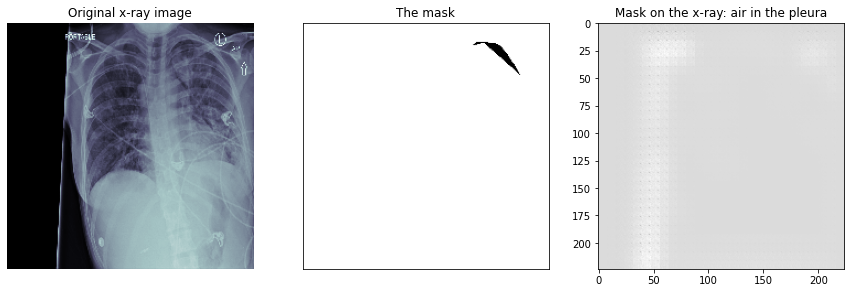

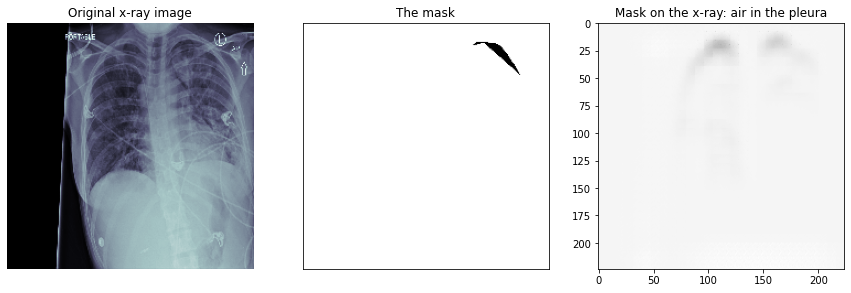

In [20]:
EPOCHS = 10
for layer in vgg16_model.layers:
    layer.trainable=False
for epoch in range(EPOCHS):
    print("Epoch : ", epoch,"/",EPOCHS)
    history=model_test.fit(image_generator,
        validation_data = valid_generator,
        batch_size = 8,
        epochs = 1,
        #   callbacks = (EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))
        )
    evaluemodel(vals, model_test, size=(224,224))

In [23]:
model_test.save("model.h5")

In [ ]:
# x_data = list(df_patients.values[:,-1])
# y_data = list(df_patients.values[:,1])

# transforms = Compose([
#         DenseTarget(),
#         Resize(input_size=(256, 256, 3), target_size=(256, 256)),
#         MoveAxis(),
#         Normalize01(),
#         AlbuSeg2d(albu=albumentations.HorizontalFlip(p=0.5)),
# ])
# random_seed = 42
# train_size = 0.8

# x_train, x_valid = train_test_split(
#     x_data,
#     random_state=random_seed,
#     train_size=train_size,
#     shuffle=True
# )

# y_train, y_valid = train_test_split(
#     y_data,
#     random_state=random_seed,
#     train_size=train_size,
#     shuffle=False)

In [ ]:
#  de du doan ta can loai bo nhung nguoi khoa manh di
# de segmatation data
df_pneumo = df_patients[df_patients["EncodedPixels"] != ' -1']

#print(df_pneumo.values[3][2], df_pneumo.values[3][3])
# print(df_pneumo.values[3][1])
mask = rle2mask(df_pneumo.values[3][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
print("Shape : ", mask.dtype)
img = pydicom.read_file(df_pneumo.values[3][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)

mask = rle2mask(df_pneumo.values[6][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
img = pydicom.read_file(df_pneumo.values[6][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, Callback



class CustomCallback(Callback):
  
  
  def on_epoch_end(self, epoch, logs=None):
    
    predict_path()

In [ ]:
def predict_path(figsize = (16, 8)):
    img = pydicom.read_file(vals.values[3][-1]).pixel_array
    img = cv2.resize(img, (512,512))
    print(type(vals.values[3][-1]))
    mask = rle2mask(df_pneumo.values[3][1], 1024, 1024)
    mask = np.rot90(mask, 3) #rotating three times 90 to the right place
    mask = np.flip(mask, axis=1)
    mask = cv2.resize(mask, (512,512))

    img_expand = img[np.newaxis, ...]
    img_pred = model2.predict(img_expand).reshape(512, 512)
    # img_pred[img_pred < 0.5] = 0
    # img_pred[img_pred >= 0.5] = 1


    fig = plt.figure(figsize=(15, 10))
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(img, cmap='bone') #original x-ray
    a.set_title("Original x-ray image")
    plt.grid(False)
    plt.axis("off")

    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(mask, cmap='binary')
    a.set_title("The mask")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    a = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow(img_pred)
    a.set_title("The predict")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()


# predict_path()

In [ ]:
# !rm -rf /content/drive/MyDrive/checkpionunet
# !mkdir /content/drive/MyDrive/checkpionunet

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# image_generator.__len__()
# model2 = _create_model2()
# model2.load_weights(filepath)
filepath = "/content/drive/MyDrive/checkpionunet"
checkpoint_path = "/content/drive/MyDrive/checkpionunet/cp.ckpt"
# checkpoin = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model2 = tf.keras.models.load_model("/content/drive/MyDrive/model_save")
history = model2.fit(image_generator,
          steps_per_epoch=100,
        #   validation_data=test_image,
        #   callbacks=[checkpoin],
          epochs=100,
          callbacks = [CustomCallback(),cp_callback]
          )

Evalua

In [ ]:
model2.save("/content/drive/MyDrive/model_save")


In [ ]:
model2 = tf.keras.models.load_model("/content/drive/MyDrive/model_save")

In [ ]:
img = pydicom.read_file(vals.values[3][-1]).pixel_array
img = cv2.resize(img, (512,512)) /255
img = img.reshape((1,512,512,1))
y = model2.predict(img)
y = y.reshape((512,512))
plt.imshow(y)

In [ ]:
vals
def evaluemodel(vals, model):
    for row in vals.values:
        mask = rle2mask(values.values[3][1], 1024, 1024)
        mask = np.rot90(mask, 3) #rotating three times 90 to the right place
        mask = np.flip(mask, axis=1)
        mask = cs2.resize(mask, (512,512))
        img = pydicom.read_file(values.values[3][-1]).pixel_array
        img = img.resize(512)

        fig = plt.figure(figsize=(15, 10))
        a = fig.add_subplot(1, 3, 1)
        plt.imshow(img, cmap='bone') #original x-ray
        a.set_title("Original x-ray image")
        plt.grid(False)
        plt.axis("off")
        

        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(mask, cmap='binary')
        a.set_title("The mask")
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        a = fig.add_subplot(1, 3, 3)
        pred = model.predict(img)
        plt.imshow(img, cmap='bone')
        plt.imshow(mask, cmap='binary', alpha=0.3)
        a.set_title("Mask on the x-ray: air in the pleura")

In [ ]:
 '''   def call(self, inputs):
        x_1 = self.x_1(inputs)
        # x_1_down = self.x_1_down(x_1)
        x_2 = self.x_2(self.x_1_down(x_1))
        # x_2_down = self.x_2_down(x_2)
        x_3 = self.x_3(self.x_2_down(x_2))
        # x_3_down = self.x_3_down(x_3)
        x_4 = self.x_4(self.x_3_down(x_3))
        # x_4_down = self.x_4_down(x_4)
        # x_5 = self.x_5(x_4_down)
        x_5_up = self.x_5_up(self.x_5(self.x_4_down(x_4)))
        # x_6 = self.x_6(tf.concat((x_4, x_5_up), axis=-1))
        x_6_up = self.x_6_up(self.x_6(tf.concat((x_4, x_5_up), axis=-1)))
        # x_7 = self.x_7(tf.concat((x_3, x_6_up), axis=-1))
        x_7_up = self.x_7_up(self.x_7(tf.concat((x_3, x_6_up), axis=-1)))
        # x_8 = self.x_8(tf.concat((x_2, x_7_up), axis=-1))
        x_8_up = self.x_8_up(self.x_8(tf.concat((x_2, x_7_up), axis=-1)))
        # x_9 = self.x_9(tf.concat((x_1, x_8_up), axis=-1))
        end = self.end(self.x_9(tf.concat((x_1, x_8_up), axis=-1)))
        return end

model = MyModel()
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])
print("fit")
history = model.fit(image_generator,
          steps_per_epoch=image_generator.__len__(),
          epochs=100  
          )'''

In [ ]:
'''class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()

        self.x_1 = self._block(2, 64, (3,3), (1,1), 'same', is_begin=True)
        self.x_1_down = layers.MaxPool2D()
        self.x_2 = self._block(2, 128, (3,3), (1,1), 'same')
        self.x_2_down = layers.MaxPool2D()
        self.x_3 = self._block(2, 256, (3,3), (1,1), 'same')
        self.x_3_down = layers.MaxPool2D()
        self.x_4 = self._block(2, 512, (3,3), (1,1), 'same')
        self.x_4_down = layers.MaxPool2D()
        self.x_5 = self._block(2, 1024, (3,3), (1,1), 'same')
        self.x_5_up = layers.Conv2DTranspose(512, (3,3), (2,2), 'same')
        self.x_6 = self._block(2, 512, (3,3), (1,1), 'same')
        self.x_6_up = layers.Conv2DTranspose(256, (3,3), (2,2), 'same')
        self.x_7 = self._block(2, 256, (3,3), (1,1), 'same')
        self.x_7_up = layers.Conv2DTranspose(128, (3,3), (2,2), 'same')
        self.x_8 = self._block(2, 128, (3,3), (1,1), 'same')
        self.x_8_up = layers.Conv2DTranspose(64, (3,3), (2,2), 'same')
        self.x_9 = self._block(2, 64, (3,3), (1,1), 'same')
        self.end = layers.Conv2D(1, (3,3), (1,1), 'same', activation='softmax')

    def _block(self, num, channels, kernel, padding, strides, 
               is_decode=False, is_begin=False, is_end=False, use_norm=False):
        blk = Sequential()       
        for i in range(num):
            if is_begin and i==0:
                # print("is_begin")
                blk.add(layers.Conv2D(channels, kernel, padding, strides, 
                                      input_shape=(INPUT_SHAPE, INPUT_SHAPE, 1)))
            else:
                blk.add(layers.Conv2D(channels, kernel, padding, strides))               
            if use_norm:
                blk.add(layers.BatchNormalization())           
            blk.add(layers.ReLU())

        return blk

    # def call(self, inputs):
    #     x_1 = self.x_1(inputs)
    #     x_1_down = self.x_1_down(x_1)
    #     x_2 = self.x_2(self.x_1_down(x_1))
    #     x_2_down = self.x_2_down(x_2)
    #     x_3 = self.x_3(self.x_2_down(x_2))
    #     x_3_down = self.x_3_down(x_3)
    #     x_4 = self.x_4(self.x_3_down(x_3))
    #     x_4_down = self.x_4_down(x_4)
    #     x_5 = self.x_5(x_4_down)
    #     x_5_up = self.x_5_up(x_5)
    #     x_6 = self.x_6(tf.concat((x_4, x_5_up), axis=-1))
    #     x_6_up = self.x_6_up(x_6)
    #     x_7 = self.x_7(tf.concat((x_3, x_6_up), axis=-1))
    #     x_7_up = self.x_7_up(x_7)
    #     x_8 = self.x_8(tf.concat((x_2, x_7_up), axis=-1))
    #     x_8_up = self.x_8_up(x_8)
    #     x_9 = self.x_9(tf.concat((x_1, x_8_up), axis=-1))
    #     end = self.end(x_9)
    #     return end
        
    def call(self, inputs):
        x_1 = self.x_1(inputs)
        # x_1_down = self.x_1_down(x_1)
        x_2 = self.x_2(self.x_1_down(x_1))
        # x_2_down = self.x_2_down(x_2)
        x_3 = self.x_3(self.x_2_down(x_2))
        # x_3_down = self.x_3_down(x_3)
        x_4 = self.x_4(self.x_3_down(x_3))
        # x_4_down = self.x_4_down(x_4)
        # x_5 = self.x_5(x_4_down)
        x_5_up = self.x_5_up(self.x_5(self.x_4_down(x_4)))
        # x_6 = self.x_6(tf.concat((x_4, x_5_up), axis=-1))
        x_6_up = self.x_6_up(self.x_6(tf.concat((x_4, x_5_up), axis=-1)))
        # x_7 = self.x_7(tf.concat((x_3, x_6_up), axis=-1))
        x_7_up = self.x_7_up(self.x_7(tf.concat((x_3, x_6_up), axis=-1)))
        # x_8 = self.x_8(tf.concat((x_2, x_7_up), axis=-1))
        x_8_up = self.x_8_up(self.x_8(tf.concat((x_2, x_7_up), axis=-1)))
        # x_9 = self.x_9(tf.concat((x_1, x_8_up), axis=-1))
        end = self.end(self.x_9(tf.concat((x_1, x_8_up), axis=-1)))
        return end

model = MyModel()
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])
print("fit")
history = model.fit(image_generator,
          steps_per_epoch=image_generator.__len__(),
          epochs=100  
          )

model = MyModel()
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])
print("fit")
history = model.fit(image_generator,
          steps_per_epoch=image_generator.__len__(),
          epochs=100  
          )'''

In [ ]:
class UnetModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input = Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 1))
    
    def _downsample_cnn_block(block_input, channel, is_first = False):
        if is_first:  
            conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(block_input)
            print(conv1.shape)
            conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
            return [block_input, conv1, conv2]
        else:
            maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
            conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(maxpool)
            conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
            return [maxpool, conv1, conv2]
    
    def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):  
        # Upsampling block
        uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
        # Crop block counterpart
        shape_input = uppool1.shape[2]
        shape_counterpart = block_counterpart.shape[2]
        crop_size = int((shape_counterpart-shape_input)/2)
        # Có thể bỏ qua crop vì các nhánh đã bằng kích thước.
        block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
        concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
        conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
        conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
        if is_last:
            conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv2)
            return [concat, conv1, conv2, conv3]
        return [uppool1, concat, conv1, conv2]
    
    def _create_model2():
        ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 1)), channel=64, is_first = True)
        ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
        ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
        ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
        ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
        us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
        us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
        us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
        us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
        model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
        model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
        return model
    
    def call(self, inputs):

In [ ]:
import tensorflow as tf

INPUT_SHAPE = 256
OUTPUT_SHAPE = 256

def _downsample_cnn_block(block_input, channel, is_first = False):
  if is_first:  
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(block_input)
    print(conv1.shape)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(maxpool)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):  
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  # Crop block counterpart
  shape_input = uppool1.shape[2]
  shape_counterpart = block_counterpart.shape[2]
  crop_size = int((shape_counterpart-shape_input)/2)
  # Có thể bỏ qua crop vì các nhánh đã bằng kích thước.
  block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
  if is_last:
    conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv2)
    return [concat, conv1, conv2, conv3]
  return [uppool1, concat, conv1, conv2]

from tensorflow.keras.optimizers import Adam

def _create_model2():
  ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 1)), channel=64, is_first = True)
  ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
  us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model = _create_model2()